In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Flight Delay Analysis") \
    .master("local[*]") \
    .getOrCreate()


In [4]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/user/ketkimaddiwar/airline_data/2024_*.csv")

df.show(5)
df.printSchema()
df.count()

25/05/09 23:13:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/09 23:13:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Year, Quarter, Month, DayofMonth, DayOfWeek, FlightDate, Reporting_Airline, DOT_ID_Reporting_Airline, IATA_CODE_Reporting_Airline, Tail_Number, Flight_Number_Reporting_Airline, OriginAirportID, OriginAirportSeqID, OriginCityMarketID, Origin, OriginCityName, OriginState, OriginStateFips, OriginStateName, OriginWac, DestAirportID, DestAirportSeqID, DestCityMarketID, Dest, DestCityName, DestState, DestStateFips, DestStateName, DestWac, CRSDepTime, DepTime, DepDelay, DepDelayMinutes, DepDel15, DepartureDelayGroups, DepTimeBlk, TaxiOut, WheelsOff, WheelsOn, TaxiIn, CRSArrTime, ArrTime, ArrDelay, ArrDelayMinutes, ArrDel15, ArrivalDelayGroups, ArrTimeBlk, Cancelled, CancellationCode, Diverted, CRSElapsedTime, Actual

+----+-------+-----+----------+---------+----------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+------------+---------+-------------+-------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+----------------+--------+--------------+-----------------+-------+-------+--------+-------------+------------+------------+--------+-------------+-----------------+------------+-------------+---------------+------------------+--------------+--------------------+-----------+-----------+-----------+-------------+----------------+------------+--------------+----------------+----

7079061

In [5]:
from pyspark.sql.functions import col
df.select("FlightDate", "Origin","Reporting_Airline", "Dest", "ArrDelay","DepDelay").show(20, truncate=False)
df

+----------+------+-----------------+----+--------+--------+
|FlightDate|Origin|Reporting_Airline|Dest|ArrDelay|DepDelay|
+----------+------+-----------------+----+--------+--------+
|2024-06-07|CHS   |9E               |JFK |-19.0   |-10.0   |
|2024-06-08|CHS   |9E               |JFK |-11.0   |-6.0    |
|2024-06-09|CHS   |9E               |JFK |-12.0   |-4.0    |
|2024-06-10|CHS   |9E               |JFK |200.0   |223.0   |
|2024-06-11|CHS   |9E               |JFK |-13.0   |-3.0    |
|2024-06-12|CHS   |9E               |JFK |-18.0   |-2.0    |
|2024-06-13|CHS   |9E               |JFK |726.0   |677.0   |
|2024-06-14|CHS   |9E               |JFK |-12.0   |-1.0    |
|2024-06-15|CHS   |9E               |JFK |-8.0    |-1.0    |
|2024-06-16|CHS   |9E               |JFK |-16.0   |-2.0    |
|2024-06-17|CHS   |9E               |JFK |-12.0   |-1.0    |
|2024-06-18|CHS   |9E               |JFK |2.0     |6.0     |
|2024-06-19|CHS   |9E               |JFK |-5.0    |-8.0    |
|2024-06-20|CHS   |9E   

DataFrame[Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, FlightDate: date, Reporting_Airline: string, DOT_ID_Reporting_Airline: int, IATA_CODE_Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, Dest: string, DestCityName: string, DestState: string, DestStateFips: int, DestStateName: string, DestWac: int, CRSDepTime: int, DepTime: int, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: int, DepTimeBlk: string, TaxiOut: double, WheelsOff: int, WheelsOn: int, TaxiIn: double, CRSArrTime: int, ArrTime: int, ArrDelay: double, ArrDelayMinutes: double, ArrDel15: double, ArrivalDelayGroups: int, ArrTimeBlk: string, Cancelled: double, CancellationCod

In [6]:
import pandas as pd

# Load airport info
airports_df = pd.read_csv("airports.csv")

# Filter valid IATA codes only
airports_df = airports_df[airports_df["iata_code"].notnull()]

# Build IATA → (lat, lon) mapping
iata_coords = dict(zip(
    airports_df["iata_code"],
    zip(airports_df["latitude_deg"], airports_df["longitude_deg"])
))

# Sample output
print("Example:", {k: iata_coords[k] for k in list(iata_coords)[:5]})


Example: {'UTK': (11.222219, 169.851429), 'OCA': (25.325399398804, -80.274803161621), 'CUX': (27.7211, -97.512802), 'CSE': (38.851918, -106.928341), 'CUS': (31.823898, -107.629924)}


In [7]:
# Extract all unique IATA airport codes involved in weather-delayed flights
from pyspark.sql.functions import col, to_date

# Convert date column
df = df.withColumn("FlightDate", to_date(col("FlightDate"), "yyyy-MM-dd"))

# Extract unique IATA codes
airport_codes = df.select("Origin").union(df.select("Dest")) \
    .distinct().rdd.flatMap(lambda x: x).collect()

print("Airports codes", airport_codes)

Airports codes ['BGM', 'DLG', 'PSE', 'MSY', 'PPG', 'GEG', 'SNA', 'BUR', 'GRB', 'GTF', 'IDA', 'GRR', 'PVU', 'EUG', 'PSG', 'GSO', 'MYR', 'PVD', 'OAK', 'MQT', 'MSN', 'FAR', 'FSM', 'SCC', 'DCA', 'RFD', 'GTR', 'MLU', 'CID', 'WRG', 'IAG', 'LEX', 'RDM', 'ORF', 'EVV', 'KTN', 'CWA', 'SAV', 'GCK', 'TRI', 'CDV', 'CMH', 'ADK', 'CAK', 'CHO', 'MOB', 'PNS', 'LIH', 'IAH', 'HNL', 'SHV', 'GST', 'CVG', 'SJC', 'TOL', 'LGA', 'BUF', 'TLH', 'ACT', 'HPN', 'MLI', 'AUS', 'SJU', 'ATW', 'DHN', 'AVL', 'LGB', 'GJT', 'BFL', 'GFK', 'SRQ', 'RNO', 'EYW', 'SBN', 'TTN', 'RST', 'JAC', 'CHS', 'HGR', 'TUL', 'RSW', 'HRL', 'ISP', 'AMA', 'BOS', 'MLB', 'MAF', 'EWR', 'LAS', 'BIS', 'FAI', 'JAN', 'ITO', 'XNA', 'HHH', 'DLH', 'HYA', 'DEN', 'ALB', 'OME', 'GRI', 'SBA', 'PSP', 'IAD', 'BOI', 'DRO', 'BRO', 'BMI', 'SEA', 'CMI', 'PBG', 'LRD', 'VLD', 'PSM', 'MCI', 'GRK', 'CLT', 'TVC', 'BNA', 'PAE', 'CLL', 'PSC', 'BLI', 'ORH', 'ABQ', 'PBI', 'PIE', 'SDF', 'SCK', 'BDL', 'ITH', 'MRY', 'DAL', 'USA', 'CLE', 'PDX', 'ACK', 'MIA', 'MFR', 'BWI', 'TPA

In [8]:
from meteostat import Stations, Hourly
from datetime import datetime
import pandas as pd

start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)

weather_dataframes = []

def fetch_full_hourly_weather(iata_code, start, end):
    if iata_code not in iata_coords:
        return pd.DataFrame()

    lat, lon = iata_coords[iata_code]
    stations = Stations().nearby(lat, lon).fetch(5)

    for i in range(len(stations)):
        station_id = stations.index[i]
        h_start = pd.to_datetime(stations.iloc[i]['hourly_start'])
        h_end = pd.to_datetime(stations.iloc[i]['hourly_end'])

        if start >= h_start and end <= h_end:
            try:
                df = Hourly(station_id, start, end).fetch()
                if df.empty:
                    continue
                df = df.reset_index()
                df["Airport"] = iata_code
                df["StationID"] = station_id
                df.rename(columns={"time": "WeatherDate"}, inplace=True)
                return df[["WeatherDate", "Airport", "temp", "wspd", "prcp", "rhum"]]
            except:
                continue
    return pd.DataFrame()

# Now use it like before
for code in airport_codes:
    print(f"📡 Fetching weather for {code}...")
    wdf = fetch_full_hourly_weather(code, start, end)
    if not wdf.empty:
        weather_dataframes.append(wdf)
        print(f"{code}: {len(wdf)} records")
    else:
        print(f"⚠️ No data for {code}")


📡 Fetching weather for BGM...
BGM: 8553 records
📡 Fetching weather for DLG...
DLG: 8760 records
📡 Fetching weather for PSE...
PSE: 8758 records
📡 Fetching weather for MSY...
MSY: 8761 records
📡 Fetching weather for PPG...
PPG: 8761 records
📡 Fetching weather for GEG...
GEG: 8761 records
📡 Fetching weather for SNA...
SNA: 8760 records
📡 Fetching weather for BUR...
BUR: 8761 records
📡 Fetching weather for GRB...
GRB: 8761 records
📡 Fetching weather for GTF...
GTF: 8761 records
📡 Fetching weather for IDA...
IDA: 8761 records
📡 Fetching weather for GRR...
GRR: 8761 records
📡 Fetching weather for PVU...
PVU: 8760 records
📡 Fetching weather for EUG...
EUG: 8761 records
📡 Fetching weather for PSG...
PSG: 8758 records
📡 Fetching weather for GSO...
GSO: 8761 records
📡 Fetching weather for MYR...
MYR: 8754 records
📡 Fetching weather for PVD...
PVD: 8760 records
📡 Fetching weather for OAK...
OAK: 8761 records
📡 Fetching weather for MQT...
MQT: 8626 records
📡 Fetching weather for MSN...
MSN: 8553 

SAF: 8761 records
📡 Fetching weather for ELP...
ELP: 8761 records
📡 Fetching weather for BHM...
BHM: 8761 records
📡 Fetching weather for ATL...
ATL: 8761 records
📡 Fetching weather for FLL...
FLL: 8761 records
📡 Fetching weather for FNT...
FNT: 8721 records
📡 Fetching weather for AZA...
AZA: 8689 records
📡 Fetching weather for RIC...
RIC: 8761 records
📡 Fetching weather for AKN...
AKN: 8748 records
📡 Fetching weather for LCK...
LCK: 8759 records
📡 Fetching weather for DAY...
DAY: 8761 records
📡 Fetching weather for OMA...
OMA: 8761 records
📡 Fetching weather for SJT...
SJT: 8757 records
📡 Fetching weather for LCH...
LCH: 8563 records
📡 Fetching weather for STC...
STC: 8761 records
📡 Fetching weather for VPS...
VPS: 8759 records
📡 Fetching weather for MHK...
MHK: 8761 records
📡 Fetching weather for LIT...
LIT: 8563 records
📡 Fetching weather for MVY...
MVY: 8761 records
📡 Fetching weather for CAE...
CAE: 8761 records
📡 Fetching weather for FAT...
FAT: 8761 records
📡 Fetching weather for

In [9]:
df = df.withColumn("FlightDate", to_date(col("FlightDate"), "yyyy-MM-dd"))

In [10]:
weather_df = pd.concat(weather_dataframes, ignore_index=True)
weather_df

,WeatherDate,Airport,temp,wspd,prcp,rhum
0,2024-01-01 00:00:00,BGM,0.0,6.0,0.0,86.0
1,2024-01-01 01:00:00,BGM,0.0,4.3,0.0,93.0
2,2024-01-01 02:00:00,BGM,0.0,6.0,0.0,93.0
3,2024-01-01 03:00:00,BGM,0.0,6.1,0.0,93.0
4,2024-01-01 04:00:00,BGM,0.0,4.7,0.1,93.0
...,...,...,...,...,...,...
3040726,2024-12-30 20:00:00,VEL,1.1,5.4,0.0,79.0
3040727,2024-12-30 21:00:00,VEL,2.8,7.6,0.0,64.0
3040728,2024-12-30 22:00:00,VEL,2.8,9.4,0.0,59.0
3040729,2024-12-30 23:00:00,VEL,1.1,7.6,0.0,67.0


In [11]:
weather_df["Date"] = pd.to_datetime(weather_df["WeatherDate"]).dt.date
weather_df["Hour"] = pd.to_datetime(weather_df["WeatherDate"]).dt.hour
weather_df

,WeatherDate,Airport,temp,wspd,prcp,rhum,Date,Hour
0,2024-01-01 00:00:00,BGM,0.0,6.0,0.0,86.0,2024-01-01,0
1,2024-01-01 01:00:00,BGM,0.0,4.3,0.0,93.0,2024-01-01,1
2,2024-01-01 02:00:00,BGM,0.0,6.0,0.0,93.0,2024-01-01,2
3,2024-01-01 03:00:00,BGM,0.0,6.1,0.0,93.0,2024-01-01,3
4,2024-01-01 04:00:00,BGM,0.0,4.7,0.1,93.0,2024-01-01,4
...,...,...,...,...,...,...,...,...
3040726,2024-12-30 20:00:00,VEL,1.1,5.4,0.0,79.0,2024-12-30,20
3040727,2024-12-30 21:00:00,VEL,2.8,7.6,0.0,64.0,2024-12-30,21
3040728,2024-12-30 22:00:00,VEL,2.8,9.4,0.0,59.0,2024-12-30,22
3040729,2024-12-30 23:00:00,VEL,1.1,7.6,0.0,67.0,2024-12-30,23


In [12]:
from pyspark.sql.functions import floor, col, hour, to_date

df = df.withColumn("DepHour", floor(col("DepTime") / 100))
df = df.withColumn("ArrHour", floor(col("ArrTime") / 100))
df = df.withColumn("Date", to_date(col("FlightDate"), "yyyy-MM-dd"))

In [13]:
df_flight_filtered = df.select(
    "Date", "DepHour", "ArrHour", "Origin", "Dest",
    "FlightDate", "DepTime", "ArrTime", "DepDelay", "ArrDelay"
)

In [14]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DateType, IntegerType, TimestampType

weather_schema = StructType([
    StructField("WeatherDate",     TimestampType(), True),
    StructField("Airport",         StringType(),    True),
    StructField("temp",            FloatType(),     True),
    StructField("wspd",            FloatType(),     True),
    StructField("prcp",            FloatType(),     True),
    StructField("rhum",            FloatType(),     True),
    StructField("Date",            DateType(),      True),
    StructField("Hour",            IntegerType(),   True),
])

# Make sure weather_df (Pandas DataFrame) exists and is populated
# Convert WeatherDate to UTC datetime format to prevent timezone issues
weather_df["WeatherDate"] = pd.to_datetime(weather_df["WeatherDate"], utc=True)

# Convert to Spark DataFrame
weather_spark_df = spark.createDataFrame(weather_df, schema=weather_schema)


In [15]:
joined_df = df_flight_filtered.join(
    weather_spark_df,
    (df_flight_filtered["Date"] == weather_spark_df["Date"]) &
    (df_flight_filtered["DepHour"] == weather_spark_df["Hour"]) &
    (df_flight_filtered["Origin"] == weather_spark_df["Airport"]),
    how="left"
).drop(weather_spark_df["Date"]).drop(weather_spark_df["Hour"]).drop(weather_spark_df["Airport"])


In [16]:
joined_df = joined_df.withColumnRenamed("temp", "origin_temp") \
    .withColumnRenamed("wspd", "origin_wspd") \
    .withColumnRenamed("prcp", "origin_prcp") \
    .withColumnRenamed("rhum", "origin_rhum") \
    .withColumnRenamed("WeatherDate", "origin_weather_time")



In [17]:
joined_df.select(
    "FlightDate", "Origin", "DepHour", "DepDelay", 
    "origin_weather_time", "origin_temp", "origin_prcp", "origin_rhum"
).show(10, truncate=False)


25/05/09 23:15:40 WARN TaskSetManager: Stage 11 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


+----------+------+-------+--------+-------------------+-----------+-----------+-----------+
|FlightDate|Origin|DepHour|DepDelay|origin_weather_time|origin_temp|origin_prcp|origin_rhum|
+----------+------+-------+--------+-------------------+-----------+-----------+-----------+
|2024-01-15|LGA   |9      |23.0    |2024-01-15 01:00:00|-4.4       |0.0        |40.0       |
|2024-01-22|LGA   |8      |-3.0    |2024-01-22 00:00:00|-3.3       |0.0        |55.0       |
|2024-01-25|JAX   |13     |-2.0    |2024-01-25 05:00:00|20.6       |0.0        |90.0       |
|2024-03-01|AVL   |11     |-7.0    |2024-03-01 03:00:00|4.4        |0.0        |57.0       |
|2024-03-06|CMH   |6      |3.0     |2024-03-05 22:00:00|13.3       |0.0        |93.0       |
|2024-03-06|IAD   |12     |-5.0    |2024-03-06 04:00:00|11.7       |0.0        |93.0       |
|2024-03-07|AVL   |11     |-13.0   |2024-03-07 03:00:00|11.7       |0.0        |86.0       |
|2024-03-11|AVL   |12     |50.0    |2024-03-11 05:00:00|1.7        |0.

In [18]:
from pyspark.sql.functions import floor, col, to_date

# Convert ArrTime to hour
df = df.withColumn("ArrHour", floor(col("ArrTime") / 100))

# Continue your existing columns
df = df.withColumn("DepHour", floor(col("DepTime") / 100))
df = df.withColumn("Date", to_date(col("FlightDate"), "yyyy-MM-dd"))

# Include ArrHour in the filtered DataFrame!
df_flight_filtered = df.select("Date", "DepHour", "ArrHour", "Origin", "Dest", "FlightDate", "DepTime", "DepDelay", "ArrDelay")

In [19]:
dest_weather_df = weather_spark_df \
    .withColumnRenamed("Airport", "Dest") \
    .withColumnRenamed("temp", "dest_temp") \
    .withColumnRenamed("wspd", "dest_wspd") \
    .withColumnRenamed("prcp", "dest_prcp") \
    .withColumnRenamed("rhum", "dest_rhum") \
    .withColumnRenamed("WeatherDate", "dest_weather_time") \
    .withColumnRenamed("Hour", "ArrHour")


In [20]:
from pyspark.sql.functions import col

# Alias both DataFrames before join
df_alias = df.alias("f")
weather_dest_alias = dest_weather_df.alias("w")

# Perform join using aliases
joined_df = df_alias.join(
    weather_dest_alias,
    (col("f.Dest") == col("w.Dest")) &
    (col("f.Date") == col("w.Date")) &
    (col("f.ArrHour") == col("w.ArrHour")),
    "left"
)

# Select disambiguated columns
joined_df.select(
    "f.FlightDate", "f.Origin", "f.Dest", "f.DepDelay", "f.ArrDelay",
    "w.dest_temp", "w.dest_wspd", "w.dest_prcp", "w.dest_rhum"
).show(10, truncate=False)


25/05/09 23:16:00 WARN TaskSetManager: Stage 16 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


+----------+------+----+--------+--------+---------+---------+---------+---------+
|FlightDate|Origin|Dest|DepDelay|ArrDelay|dest_temp|dest_wspd|dest_prcp|dest_rhum|
+----------+------+----+--------+--------+---------+---------+---------+---------+
|2024-12-01|IAH   |ATL |46.0    |34.0    |12.2     |13.0     |0.0      |30.0     |
|2024-06-10|ORD   |AVP |16.0    |26.0    |16.1     |13.0     |0.0      |62.0     |
|2024-01-25|JAX   |BWI |-3.0    |-17.0   |8.3      |0.0      |0.3      |93.0     |
|2024-05-03|ORD   |CLT |-6.0    |-1.0    |19.4     |0.0      |0.0      |84.0     |
|2024-09-01|ABQ   |DAL |3.0     |-7.0    |31.1     |16.6     |0.0      |54.0     |
|2024-09-01|ABQ   |DEN |-10.0   |-16.0   |19.4     |13.0     |0.0      |32.0     |
|2024-10-29|ORD   |DEN |-9.0    |-21.0   |6.7      |13.0     |0.0      |47.0     |
|2024-12-28|ORD   |IAH |2.0     |-7.0    |21.1     |7.6      |0.0      |93.0     |
|2024-06-17|CHS   |JFK |-1.0    |-12.0   |18.3     |9.4      |0.0      |93.0     |
|202

In [21]:
origin_weather_df = weather_spark_df.select(
    col("Date"),
    col("Hour").alias("DepHour"),
    col("Airport").alias("Origin"),
    col("WeatherDate").alias("origin_weather_time"),
    col("temp").alias("origin_temp"),
    col("wspd").alias("origin_wspd"),
    col("prcp").alias("origin_prcp"),
    col("rhum").alias("origin_rhum")
)



In [22]:
flight_with_origin = df.join(
    origin_weather_df,
    on=["Date", "Origin", "DepHour"],
    how="left"
)


In [23]:
dest_weather_df = weather_spark_df.select(
    col("Date"),
    col("Hour").alias("ArrHour"),
    col("Airport").alias("Dest"),
    col("WeatherDate").alias("dest_weather_time"),
    col("temp").alias("dest_temp"),
    col("wspd").alias("dest_wspd"),
    col("prcp").alias("dest_prcp"),
    col("rhum").alias("dest_rhum")
)

In [24]:
from pyspark.sql.functions import floor, col, to_date

df = df.withColumn("ArrHour", floor(col("ArrTime") / 100))
df = df.withColumn("Date", to_date(col("FlightDate"), "yyyy-MM-dd"))


In [30]:
final_df = flight_with_origin.join(
    dest_weather_df,
    on=["Date", "Dest", "ArrHour"],
    how="left"
)


In [26]:
final_df.select("FlightDate", "Origin", "Dest", "origin_temp", "dest_temp",
                "origin_wspd","dest_wspd","origin_prcp","dest_prcp","origin_rhum","dest_rhum").limit(5).show()



25/05/09 23:16:14 WARN TaskSetManager: Stage 21 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


+----------+------+----+--------+--------+-----------+---------+-----------+---------+-----------+---------+-----------+---------+
|FlightDate|Origin|Dest|DepDelay|ArrDelay|origin_temp|dest_temp|origin_wspd|dest_wspd|origin_prcp|dest_prcp|origin_rhum|dest_rhum|
+----------+------+----+--------+--------+-----------+---------+-----------+---------+-----------+---------+-----------+---------+
|2024-01-25|   JAX| BWI|    -5.0|   -12.0|       26.7|     16.1|       16.6|      5.4|        0.0|      0.0|       64.0|     90.0|
|2024-02-29|   XWA| DEN|    -7.0|   -24.0|       -7.0|      2.2|       19.0|      5.4|        0.0|      0.0|       81.0|     38.0|
|2024-02-29|   GSP| DEN|    -6.0|   -24.0|        6.1|     13.9|       13.0|      0.0|        0.0|      0.0|       29.0|     15.0|
|2024-03-06|   ORD| AVL|     1.0|     4.0|        7.8|     12.2|       29.5|      5.4|        0.0|      0.3|       53.0|     93.0|
|2024-04-08|   ACY| TPA|   -12.0|   -18.0|        0.6|     21.7|        0.0|     11

In [27]:
# Example using pandas (after collecting a sample)
sample_df = final_df.select("DepDelay", "ArrDelay", 
                            "origin_temp", "origin_wspd", "origin_prcp", "origin_rhum",
                            "dest_temp", "dest_wspd", "dest_prcp", "dest_rhum").limit(100).toPandas()

sample_df.corr(numeric_only=True)


25/05/09 23:16:20 WARN TaskSetManager: Stage 30 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


[780.288s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 33.0 (TID 249): Retried waiting for GCLocker too often allocating 524290 words


25/05/09 23:16:21 WARN TaskMemoryManager: Failed to allocate a page (4194304 bytes), try again.


,DepDelay,ArrDelay,origin_temp,origin_wspd,origin_prcp,origin_rhum,dest_temp,dest_wspd,dest_prcp,dest_rhum
DepDelay,1.000000,0.925536,-0.160611,0.069060,0.004192,-0.054048,-0.101589,0.049838,0.158713,0.021363
ArrDelay,0.925536,1.000000,-0.171419,0.185089,0.002803,-0.049116,-0.097665,0.081012,0.139422,0.052381
origin_temp,-0.160611,-0.171419,1.000000,-0.062692,0.074085,-0.053150,0.386556,-0.107731,-0.073842,0.110663
origin_wspd,0.069060,0.185089,-0.062692,1.000000,-0.078342,-0.292552,-0.018898,0.145863,0.105834,-0.033451
origin_prcp,0.004192,0.002803,0.074085,-0.078342,1.000000,0.283506,0.124869,0.049121,0.085879,0.002664
origin_rhum,-0.054048,-0.049116,-0.053150,-0.292552,0.283506,1.000000,0.141729,-0.086799,0.122834,0.070918
dest_temp,-0.101589,-0.097665,0.386556,-0.018898,0.124869,0.141729,1.000000,-0.106073,0.062707,-0.180054
dest_wspd,0.049838,0.081012,-0.107731,0.145863,0.049121,-0.086799,-0.106073,1.000000,0.088601,0.040305
dest_prcp,0.158713,0.139422,-0.073842,0.105834,0.085879,0.122834,0.062707,0.088601,1.000000,0.275277
dest_rhum,0.021363,0.052381,0.110663,-0.033451,0.002664,0.070918,-0.180054,0.040305,0.275277,1.000000


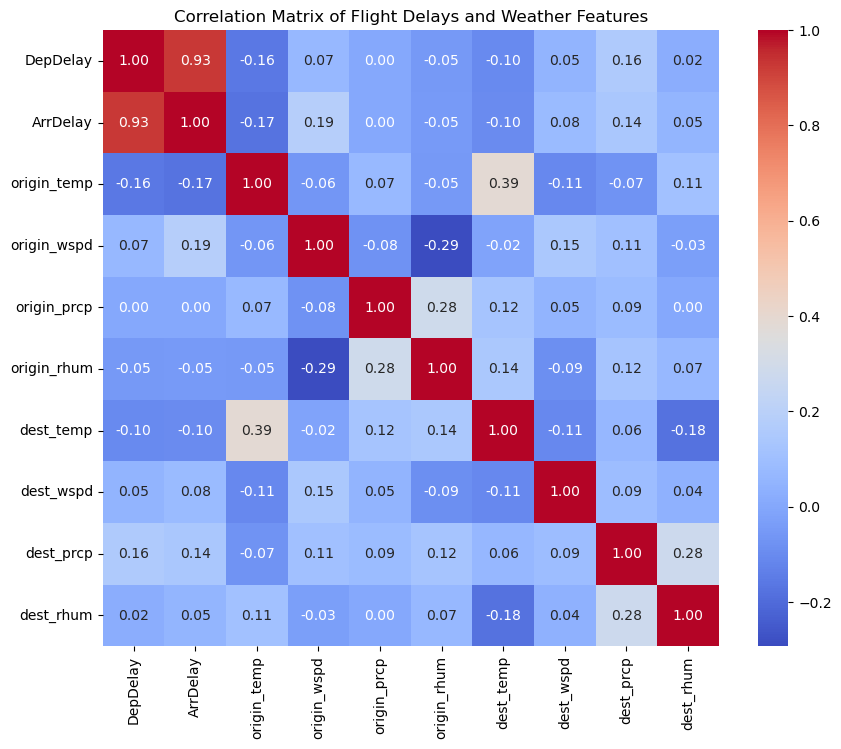

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have your sample pandas DataFrame as `sample_df`
plt.figure(figsize=(10, 8))
sns.heatmap(sample_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Flight Delays and Weather Features")
plt.show()


In [33]:
from pyspark.sql.functions import mean, avg, col, when, month, count

# 1. Overall average stats
overview_stats = final_df.select(
    mean("DepDelay").alias("avg_dep_delay"),
    mean("ArrDelay").alias("avg_arr_delay"),
    mean("origin_temp").alias("avg_origin_temp"),
    mean("dest_temp").alias("avg_dest_temp"),
    mean("origin_prcp").alias("avg_origin_prcp"),
    mean("dest_prcp").alias("avg_dest_prcp"),
    mean("origin_wspd").alias("avg_origin_wspd"),
    mean("dest_wspd").alias("avg_dest_wspd")
)
overview_stats.show()

# 2. Delay vs Origin Temp Buckets
bucketed_df = final_df.withColumn(
    "origin_temp_bucket", 
    when(col("origin_temp") <= 0, "Cold")
    .when(col("origin_temp") <= 15, "Cool")
    .when(col("origin_temp") <= 30, "Warm")
    .otherwise("Hot")
)

temp_bucket_delay = bucketed_df.groupBy("origin_temp_bucket") \
    .agg(
        avg("DepDelay").alias("avg_dep_delay"),
        avg("ArrDelay").alias("avg_arr_delay")
    ).orderBy("origin_temp_bucket")
temp_bucket_delay.show()

# 3. Monthly delay trends
monthly_delay = final_df.withColumn("month", month("FlightDate")) \
    .groupBy("month") \
    .agg(
        avg("DepDelay").alias("avg_dep_delay"),
        avg("ArrDelay").alias("avg_arr_delay")
    ).orderBy("month")
monthly_delay.show()

# 4. Airport-level delay
airport_delay = final_df.groupBy("Origin") \
    .agg(
        count("*").alias("num_flights"),
        avg("DepDelay").alias("avg_dep_delay"),
        avg("ArrDelay").alias("avg_arr_delay")
    ).orderBy(col("avg_arr_delay").desc())
airport_delay.show(10, truncate=False)


25/05/09 23:24:53 WARN TaskSetManager: Stage 43 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


+------------------+-----------------+---------------+-------------+---------------+-------------+---------------+-------------+
|     avg_dep_delay|    avg_arr_delay|avg_origin_temp|avg_dest_temp|avg_origin_prcp|avg_dest_prcp|avg_origin_wspd|avg_dest_wspd|
+------------------+-----------------+---------------+-------------+---------------+-------------+---------------+-------------+
|12.677046863546439|7.098219058132468|            NaN|          NaN|            NaN|          NaN|            NaN|          NaN|
+------------------+-----------------+---------------+-------------+---------------+-------------+---------------+-------------+



25/05/09 23:25:08 WARN TaskSetManager: Stage 57 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.
25/05/09 23:25:09 WARN TaskSetManager: Stage 58 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.
25/05/09 23:25:12 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
25/05/09 23:25:12 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
25/05/09 23:25:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:16 WARN RowBasedKeyValueBatch: Callin

+------------------+------------------+------------------+
|origin_temp_bucket|     avg_dep_delay|     avg_arr_delay|
+------------------+------------------+------------------+
|              Cold|14.350295980379604| 9.230784809626366|
|              Cool| 8.511311156840458|  1.90898530308446|
|               Hot| 24.07480899928392|19.947608611528672|
|              Warm|13.656997970349007| 8.524748603745413|
+------------------+------------------+------------------+



25/05/09 23:25:25 WARN TaskSetManager: Stage 74 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.
25/05/09 23:25:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:34 WARN RowBasedKeyValu

+-----+------------------+-------------------+
|month|     avg_dep_delay|      avg_arr_delay|
+-----+------------------+-------------------+
|    1|15.700680491379622|   10.3522983801892|
|    2|  7.45539706978861| 0.5934550690998294|
|    3|12.448735732470835|  6.504476326969165|
|    4|10.810359703771331| 5.3605435809434665|
|    5|18.090299069241084| 14.049410406090523|
|    6| 16.94572585294098| 11.807215370082092|
|    7| 22.34797877929035| 18.092325283660564|
|    8| 15.31098852938172| 10.587576100069006|
|    9|  6.64880930799498| 0.9967748183349416|
|   10| 5.443071090358529|-1.2827363051630694|
|   11| 6.216421818486503|-0.3246114492431806|
|   12|13.559404430126222|  7.116440276865835|
+-----+------------------+-------------------+



25/05/09 23:25:44 WARN TaskSetManager: Stage 88 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.
25/05/09 23:25:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:25:53 WARN RowBasedKeyValu

+------+-----------+------------------+------------------+
|Origin|num_flights|avg_dep_delay     |avg_arr_delay     |
+------+-----------+------------------+------------------+
|MGW   |37         |72.62162162162163 |69.05405405405405 |
|EWN   |51         |68.40425531914893 |58.48936170212766 |
|HTS   |426        |42.78883495145631 |41.86407766990291 |
|SMX   |106        |40.509433962264154|39.301886792452834|
|CKB   |207        |37.024752475247524|35.42574257425743 |
|HGR   |296        |35.1184668989547  |32.57342657342657 |
|HYA   |269        |26.6360153256705  |32.22093023255814 |
|OTH   |345        |35.348973607038126|29.793510324483776|
|STX   |1196       |25.730964467005077|25.457167090754876|
|SCK   |515        |24.594541910331383|24.65497076023392 |
+------+-----------+------------------+------------------+
only showing top 10 rows



25/05/09 23:26:53 WARN TaskSetManager: Stage 102 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.


[1419.716s][warning][gc,alloc] Executor task launch worker for task 5.0 in stage 105.0 (TID 514): Retried waiting for GCLocker too often allocating 2097154 words


25/05/09 23:27:00 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:27:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBat

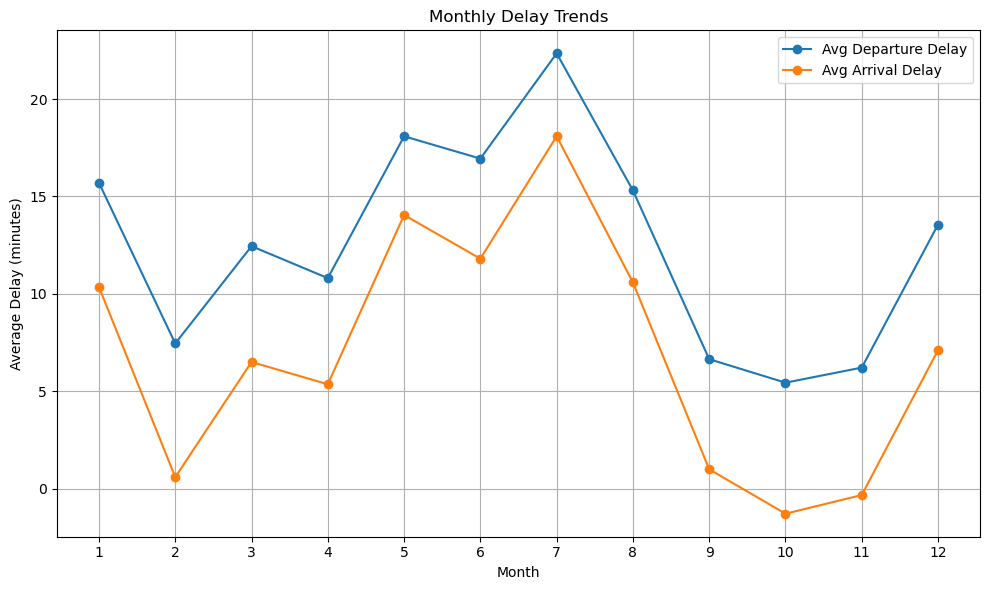

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas for plotting
monthly_pdf = monthly_delay.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_pdf["month"], monthly_pdf["avg_dep_delay"], marker='o', label='Avg Departure Delay')
plt.plot(monthly_pdf["month"], monthly_pdf["avg_arr_delay"], marker='o', label='Avg Arrival Delay')
plt.title("Monthly Delay Trends")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


25/05/09 23:33:09 WARN TaskSetManager: Stage 133 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.
25/05/09 23:33:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:33:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:33:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:33:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:33:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:33:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:33:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 23:33:18 WARN RowBasedKeyVal

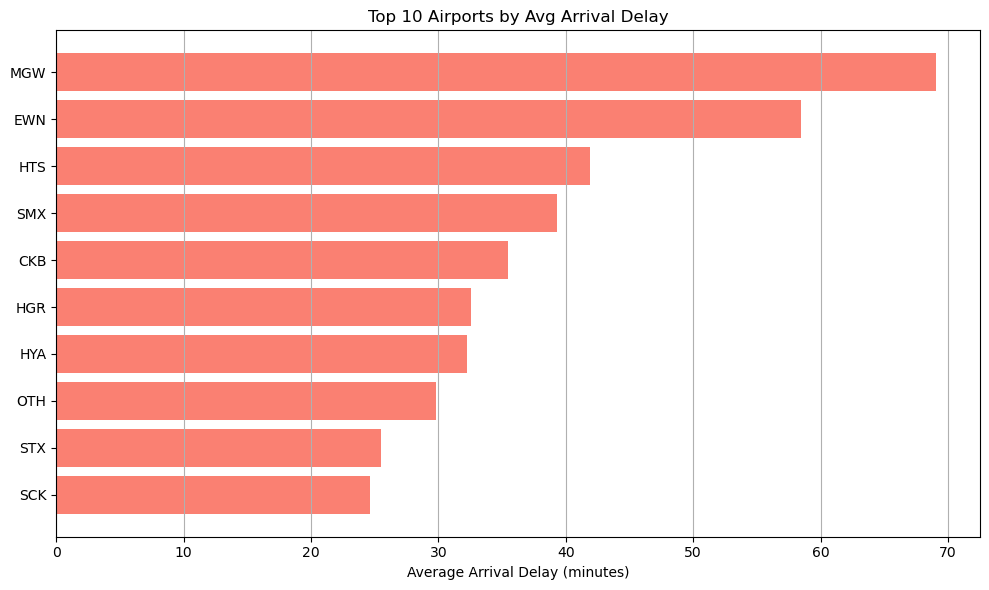

In [37]:
# Convert to pandas
airport_pdf = airport_delay.limit(10).toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(airport_pdf["Origin"], airport_pdf["avg_arr_delay"], color='salmon')
plt.xlabel("Average Arrival Delay (minutes)")
plt.title("Top 10 Airports by Avg Arrival Delay")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [38]:
final_df.createOrReplaceTempView("flights_weather")


In [39]:
top_10_delay_humidity = spark.sql("""
SELECT Reporting_Airline,
       ROUND(AVG(DepDelay), 2) AS avg_dep_delay,
       ROUND(AVG(ArrDelay), 2) AS avg_arr_delay,
       ROUND(AVG(origin_rhum), 2) AS avg_origin_humidity,
       ROUND(AVG(origin_temp), 2) AS avg_origin_temp
FROM flights_weather
WHERE origin_rhum IS NOT NULL AND origin_rhum > 85
GROUP BY Reporting_Airline
ORDER BY avg_dep_delay DESC
LIMIT 10
""")
top_10_delay_humidity.show()


25/05/09 23:44:22 WARN TaskSetManager: Stage 147 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.
25/05/09 23:44:23 WARN TaskSetManager: Stage 148 contains a task of very large size (20459 KiB). The maximum recommended task size is 1000 KiB.
25/05/09 23:44:29 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.


[2468.295s][warning][gc,alloc] Executor task launch worker for task 5.0 in stage 151.0 (TID 678): Retried waiting for GCLocker too often allocating 2097154 words


[2472.333s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 156.0 (TID 682): Retried waiting for GCLocker too often allocating 2097154 words


25/05/09 23:44:33 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.
25/05/09 23:44:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------------+-------------+-------------+-------------------+---------------+
|Reporting_Airline|avg_dep_delay|avg_arr_delay|avg_origin_humidity|avg_origin_temp|
+-----------------+-------------+-------------+-------------------+---------------+
|               AA|        19.83|        15.11|                NaN|          15.76|
|               F9|        17.05|        13.87|              91.43|          16.06|
|               B6|        14.66|         9.73|              91.86|          16.17|
|               OH|        14.25|        10.89|                NaN|            NaN|
|               OO|        13.93|        10.58|                NaN|            NaN|
|               NK|        12.54|         6.39|                NaN|          17.03|
|               G4|        11.25|         7.19|                NaN|          15.47|
|               MQ|        11.19|         7.96|                NaN|            NaN|
|               UA|        10.36|         4.71|                NaN|         